In [169]:
import csv
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import gurobipy as gp
from gurobipy import GRB
from scipy.optimize import minimize
import os
import matplotlib.dates as mdates
from datetime import datetime

In [170]:
def importClean_10ind(csv_file_path, desired_returns):
    """
    Cette fonction importe des données à partir d'un fichier CSV spécifié, effectue un nettoyage de données,
    et retourne un DataFrame contenant des données filtrées.

    Args:
        csv_file_path(str): Chemin vers le fichier CSV avec les données brutes.

    Returns:
        DataFrame: DataFrame contenant les données historiques filtrées pour les 10 industries, 
        pour les 48 industries et les facteurs de Fama-French.
    """


    # Importation
    with open(csv_file_path, 'r', newline='') as file:
        reader = csv.reader(file)
        
        # Sauter les 10 premières lignes
        for _ in range(10):
            next(reader)

        # Lire le reste du fichier CSV dans un DataFrame
        df = pd.DataFrame(reader)
        df.columns = df.iloc[1]
        df = df.drop(df.index[1])
        df = df.reset_index(drop=True)

    # Nettoyage
    df = df.rename(columns={df.columns[0]: 'Date'})
    first_row = df[df.iloc[:, 0].str.strip() == desired_returns].index
    
    # Si 'desired_returns' est 'Number of Firms in Portfolios' ou 'Average Firm Size', 
    # alors sauter une ligne supplémentaire pour accéder aux données dans le bon format
    if desired_returns in ['Number of Firms in Portfolios', 'Average Firm Size', 'Sum of BE / Sum of ME']:
        df_AEWR_monthly = df.iloc[first_row.values[0] + 2:].reset_index(drop=True)
    else:
        df_AEWR_monthly = df.iloc[first_row.values[0] + 1:].reset_index(drop=True)
        
    last_row = (df_AEWR_monthly['Date'].str.len() != 6).idxmax()
    df_AEWR_monthly = df_AEWR_monthly.iloc[:last_row]
    
    # Adapter le format de la date en fonction de 'desired_returns'
    # Condition spécifique pour le facteur BtoM (Book-to-Market)
    if desired_returns in ['Sum of BE / Sum of ME']:  
        df_AEWR_monthly['Date'] = df_AEWR_monthly['Date'].str.strip()
        df_AEWR_monthly['Date'] = pd.to_datetime(df_AEWR_monthly['Date'], format='%Y')
    else:
        df_AEWR_monthly['Date'] = pd.to_datetime(df_AEWR_monthly['Date'], format='%Y%m')
    
    df_AEWR_monthly.iloc[:, 1:] = df_AEWR_monthly.iloc[:, 1:].astype(float)

    # Vérifier si le nom du fichier contient '48_Industry_Portfolios.CSV',
    # pour appliquer un nettoyage supplémentaire pour les NaN values
    if '48_Industry_Portfolios.CSV' in os.path.basename(csv_file_path):
        df_AEWR_monthly.replace(-99.99, np.nan, inplace=True)
        df_AEWR_monthly.replace(-999, np.nan, inplace=True)
        df_AEWR_monthly.dropna(inplace=True)
        
    # Retourner le DataFrame et fixer la 'Date' comme index  
    df = df_AEWR_monthly.set_index('Date', drop=True)
    
    return df

In [171]:
csv_file_path_10ind = '/Users/thomasdeconinck/Downloads/Gestion-de-Portefeuille-Devoir-2/Partie A/Data /48_Industry_Portfolios.CSV'
df_48Ind            = importClean_10ind(csv_file_path_10ind, desired_returns='Average Value Weighted Returns -- Monthly')
df_48Ind

/var/folders/gm/cwbp26c51d14t923q1b9pdn00000gn/T/ipykernel_99104/554947541.py:56: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_AEWR_monthly.replace(-99.99, np.nan, inplace=True)


1,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1969-07-01,-8.32,-6.92,-3.53,-2.10,-4.74,-7.87,-10.15,-11.07,-3.43,-11.91,...,-3.15,-12.50,-10.09,-8.19,-9.93,-6.60,-10.18,-12.74,-9.05,-14.64
1969-08-01,4.23,4.52,5.44,6.63,3.99,6.42,11.56,9.79,4.77,2.40,...,6.08,5.59,6.38,8.21,8.98,12.76,8.80,15.06,8.89,8.38
1969-09-01,1.59,-0.58,5.28,-0.91,4.12,2.13,0.57,-0.61,-0.52,-2.64,...,1.23,-1.56,0.21,-0.75,-1.35,-2.94,7.08,-3.79,-2.54,-6.67
1969-10-01,16.95,7.97,6.84,11.64,12.42,6.28,13.57,7.59,6.41,6.72,...,3.50,4.89,11.25,6.25,9.03,10.71,5.71,4.54,10.31,3.70
1969-11-01,-1.87,-0.66,-4.91,-2.83,0.61,-8.33,-3.27,-3.97,-2.42,-2.90,...,-1.98,-7.91,-6.83,-4.08,-1.90,-8.99,-4.90,-6.23,-5.91,-2.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,0.84,-4.28,-6.43,-5.13,-2.43,-7.38,-11.17,-6.19,-6.81,-4.41,...,-2.57,-5.15,-2.69,-6.16,-4.45,-3.92,2.57,-10.45,-3.49,-2.72
2023-10-01,-5.83,-4.98,-0.39,-4.34,-4.00,-14.31,2.77,-2.05,-0.05,4.21,...,-3.46,-6.31,-0.90,0.74,-1.71,-2.89,3.49,-9.05,-6.31,-1.77
2023-11-01,-2.29,4.26,4.79,3.90,4.76,5.66,11.08,7.90,4.97,10.63,...,10.43,12.31,7.94,6.96,7.67,13.16,3.93,9.95,13.51,6.64


### Number of firm

In [172]:
csv_file_path_number_firm = '/Users/thomasdeconinck/Downloads/Gestion-de-Portefeuille-Devoir-2/Partie A/Data /48_Industry_Portfolios.CSV'
df_number_firm            = importClean_10ind(csv_file_path_number_firm, desired_returns='Number of Firms in Portfolios')
df_number_firm            = df_number_firm[df_number_firm.index >= df_48Ind.index.min()]
df_number_firm

1,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1969-07-01,5.0,65.0,14.0,15.0,11.0,43.0,24.0,23.0,92.0,70.0,...,34.0,79.0,55.0,157.0,28.0,42.0,16.0,23.0,45.0,4.0
1969-08-01,5.0,65.0,14.0,15.0,11.0,43.0,24.0,23.0,92.0,70.0,...,34.0,79.0,55.0,157.0,28.0,42.0,16.0,23.0,45.0,4.0
1969-09-01,5.0,65.0,14.0,15.0,11.0,43.0,24.0,23.0,92.0,69.0,...,34.0,79.0,55.0,156.0,28.0,42.0,15.0,23.0,45.0,4.0
1969-10-01,5.0,65.0,14.0,15.0,11.0,43.0,24.0,23.0,92.0,69.0,...,34.0,79.0,55.0,156.0,28.0,42.0,15.0,23.0,45.0,4.0
1969-11-01,5.0,65.0,14.0,15.0,11.0,43.0,24.0,23.0,91.0,69.0,...,34.0,79.0,55.0,156.0,28.0,41.0,15.0,23.0,45.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,11.0,52.0,9.0,11.0,5.0,28.0,48.0,12.0,46.0,32.0,...,10.0,65.0,88.0,143.0,59.0,391.0,99.0,32.0,91.0,222.0
2023-10-01,11.0,52.0,9.0,11.0,5.0,28.0,47.0,12.0,46.0,32.0,...,10.0,65.0,88.0,141.0,58.0,391.0,99.0,32.0,91.0,214.0
2023-11-01,11.0,50.0,9.0,11.0,5.0,28.0,47.0,12.0,45.0,32.0,...,10.0,65.0,87.0,140.0,58.0,391.0,99.0,31.0,89.0,211.0


### Average firm size

In [173]:
csv_file_path_avg_firm_size = '/Users/thomasdeconinck/Downloads/Gestion-de-Portefeuille-Devoir-2/Partie A/Data /48_Industry_Portfolios.CSV'
df_average_firm_size        = importClean_10ind(csv_file_path_avg_firm_size, desired_returns='Average Firm Size')
df_average_firm_size

/var/folders/gm/cwbp26c51d14t923q1b9pdn00000gn/T/ipykernel_99104/554947541.py:56: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_AEWR_monthly.replace(-99.99, np.nan, inplace=True)


1,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1969-07-01,58.72,260.26,438.72,200.22,339.62,109.96,92.29,187.65,558.01,65.30,...,338.90,187.43,54.73,210.75,160.04,248.48,413.62,68.67,242.25,34.20
1969-08-01,53.49,241.69,423.18,195.83,323.08,101.30,82.88,166.87,538.48,57.40,...,327.89,163.81,49.00,193.20,144.06,231.63,370.58,59.90,219.92,29.06
1969-09-01,55.69,251.86,445.86,208.21,332.39,107.63,92.46,182.65,563.05,59.08,...,346.65,171.89,52.02,209.42,156.96,260.87,415.05,68.86,238.72,31.50
1969-10-01,56.57,249.72,467.27,203.97,345.54,109.71,92.90,181.31,559.27,57.37,...,350.85,168.93,52.03,207.70,154.61,251.76,443.82,66.22,232.22,29.30
1969-11-01,65.81,269.11,499.16,227.44,388.01,116.59,105.42,195.05,600.68,61.10,...,362.47,177.03,57.86,220.31,168.52,284.74,467.88,69.21,255.67,30.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,3727.88,9717.26,38482.48,31479.88,45804.14,1486.68,8218.19,2283.09,14723.29,7885.83,...,7546.55,12494.47,5903.90,23495.82,11803.81,6718.01,15976.80,2151.82,13231.02,5492.93
2023-10-01,3759.20,9282.61,35785.58,29855.57,43935.26,1376.94,7450.69,2136.94,13714.66,7515.13,...,7335.28,11842.07,5742.23,22356.97,11467.27,6447.23,16347.32,1924.54,12741.38,5533.40
2023-11-01,3539.99,9069.90,35646.60,28558.97,42178.23,1176.47,7655.67,2089.35,13923.01,7830.64,...,7081.14,11093.72,5720.91,22674.89,11267.60,6245.95,16911.14,1804.10,12166.97,5511.84


### Market Cap

In [174]:
market_caps         = df_average_firm_size.multiply(df_number_firm)
market_caps

1,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1969-07-01,293.6,16916.9,6142.08,3003.3,3735.82,4728.28,2214.96,4315.95,51336.92,4571.0,...,11522.6,14806.97,3010.15,33087.75,4481.12,10436.16,6617.92,1579.41,10901.25,136.8
1969-08-01,267.45,15709.85,5924.52,2937.45,3553.88,4355.9,1989.12,3838.01,49540.16,4018.0,...,11148.26,12940.99,2695.0,30332.4,4033.68,9728.46,5929.28,1377.7,9896.4,116.24
1969-09-01,278.45,16370.9,6242.04,3123.15,3656.29,4628.09,2219.04,4200.95,51800.6,4076.52,...,11786.1,13579.31,2861.1,32669.52,4394.88,10956.54,6225.75,1583.78,10742.4,126.0
1969-10-01,282.85,16231.8,6541.78,3059.55,3800.94,4717.53,2229.6,4170.13,51452.84,3958.53,...,11928.9,13345.47,2861.65,32401.2,4329.08,10573.92,6657.3,1523.06,10449.9,117.2
1969-11-01,329.05,17492.15,6988.24,3411.6,4268.11,5013.37,2530.08,4486.15,54661.88,4215.9,...,12323.98,13985.37,3182.3,34368.36,4718.56,11674.34,7018.2,1591.83,11505.15,121.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,41006.68,505297.52,346342.32,346278.68,229020.7,41627.04,394473.12,27397.08,677271.34,252346.56,...,75465.5,812140.55,519543.2,3359902.26,696424.79,2626741.91,1581703.2,68858.24,1204022.82,1219430.46
2023-10-01,41351.2,482695.72,322070.22,328411.27,219676.3,38554.32,350182.43,25643.28,630874.36,240484.16,...,73352.8,769734.55,505316.24,3152332.77,665101.66,2520866.93,1618384.68,61585.28,1159465.58,1184147.6
2023-11-01,38939.89,453495.0,320819.4,314148.67,210891.15,32941.16,359816.49,25072.2,626535.45,250580.48,...,70811.4,721091.8,497719.17,3174484.6,653520.8,2442166.45,1674202.86,55927.1,1082860.33,1162998.24


### BTOM (SUM OF BE/ SUM OF ME)

In [175]:
csv_file_path_BtoM = '/Users/thomasdeconinck/Downloads/Gestion-de-Portefeuille-Devoir-2/Partie A/Data /48_Industry_Portfolios.CSV'
df_BtoM            = importClean_10ind(csv_file_path_BtoM, desired_returns='Sum of BE / Sum of ME')
df_BtoM            = df_BtoM.loc[df_BtoM.index.repeat(12)]
df_BtoM            = df_BtoM.iloc[:len(df_48Ind)]
df_BtoM.index      = df_48Ind.index
df_BtoM

/var/folders/gm/cwbp26c51d14t923q1b9pdn00000gn/T/ipykernel_99104/554947541.py:56: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_AEWR_monthly.replace(-99.99, np.nan, inplace=True)


1,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1969-07-01,0.88,0.50,0.2,0.58,0.66,0.31,0.42,0.33,0.21,0.50,...,0.36,1.32,0.49,0.41,0.24,0.60,0.54,0.27,0.74,0.60
1969-08-01,0.88,0.50,0.2,0.58,0.66,0.31,0.42,0.33,0.21,0.50,...,0.36,1.32,0.49,0.41,0.24,0.60,0.54,0.27,0.74,0.60
1969-09-01,0.88,0.50,0.2,0.58,0.66,0.31,0.42,0.33,0.21,0.50,...,0.36,1.32,0.49,0.41,0.24,0.60,0.54,0.27,0.74,0.60
1969-10-01,0.88,0.50,0.2,0.58,0.66,0.31,0.42,0.33,0.21,0.50,...,0.36,1.32,0.49,0.41,0.24,0.60,0.54,0.27,0.74,0.60
1969-11-01,0.88,0.50,0.2,0.58,0.66,0.31,0.42,0.33,0.21,0.50,...,0.36,1.32,0.49,0.41,0.24,0.60,0.54,0.27,0.74,0.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,0.65,0.43,0.1,0.13,0.28,0.39,0.17,0.59,0.14,0.19,...,0.42,0.22,0.27,0.16,0.14,0.65,0.37,0.43,0.42,0.48
2023-10-01,0.65,0.43,0.1,0.13,0.28,0.39,0.17,0.59,0.14,0.19,...,0.42,0.22,0.27,0.16,0.14,0.65,0.37,0.43,0.42,0.48
2023-11-01,0.65,0.43,0.1,0.13,0.28,0.39,0.17,0.59,0.14,0.19,...,0.42,0.22,0.27,0.16,0.14,0.65,0.37,0.43,0.42,0.48


### MOM

In [176]:
df_mom           = df_48Ind.rolling(window=12, min_periods=12).mean()
df_mom.replace(-99.99, np.nan, inplace = True)
df_mom.replace(-999, np.nan, inplace = True)
df_mom.dropna(inplace = True)

df_mom

1,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1970-06-01,-1.608333,-1.192500,-0.079167,-0.121667,1.379167,-4.351667,-2.588333,-4.757500,-1.919167,-4.050000,...,-2.296667,-4.505000,-4.432500,-2.108333,-4.271667,-0.481667,-1.880000,-4.616667,-3.060833,-7.690833
1970-07-01,-0.982500,-0.151667,0.701667,0.616667,2.065833,-2.652500,-1.698333,-2.729167,-1.250000,-2.367500,...,-1.479167,-2.764167,-3.231667,-0.444167,-3.360833,0.620833,-0.150000,-2.749167,-1.442500,-6.460833
1970-08-01,-1.360833,-0.497500,0.105833,-0.161667,1.787500,-2.236667,-2.392500,-3.003333,-1.295833,-1.963333,...,-1.340000,-2.526667,-3.212500,-0.702500,-3.523333,0.090000,-0.750833,-3.533333,-1.712500,-5.955000
1970-09-01,-0.289167,-0.032500,0.001667,0.286667,1.486667,-1.895833,-0.841667,-2.345000,-0.720833,-0.746667,...,-1.426667,-1.650000,-1.866667,-0.072500,-2.071667,0.301667,-0.614167,-1.979167,-0.775833,-4.920000
1970-10-01,-1.998333,-0.698333,-0.209167,-0.768333,1.314167,-2.781667,-2.284167,-3.220000,-1.268333,-1.613333,...,-1.936667,-2.470000,-3.435833,-0.665833,-3.153333,-1.025833,-1.920833,-3.140000,-2.250833,-6.836667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,-0.443333,0.130833,0.800833,0.579167,1.386667,0.681667,2.873333,2.539167,1.005833,1.811667,...,1.295000,1.810000,2.147500,1.186667,1.638333,0.859167,0.887500,1.377500,1.430000,2.147500
2023-10-01,-2.074167,-1.222500,0.175000,-0.571667,0.047500,-0.840000,1.854167,1.636667,0.530000,1.255833,...,0.534167,0.715833,0.934167,1.092500,0.615000,-0.496667,0.110000,0.045833,-0.054167,1.101667
2023-11-01,-2.465833,-1.114167,-0.067500,-0.516667,-0.021667,-0.790833,2.170833,0.989167,0.159167,0.682500,...,0.526667,0.895000,1.174167,1.427500,0.755000,0.169167,0.320833,-0.030833,0.355000,1.069167


### Problème de shape dataframe MoM 

In [177]:
df_BtoM      = df_BtoM.reindex(df_mom.index)
market_caps  = market_caps.reindex(df_mom.index)
df_48Ind     = df_48Ind.reindex(df_mom.index)

### Standardiser les acarcatéristics

In [178]:
def standardize(df):
    """
    Cette fonction standardise les données d'un DataFrame en utilisant la moyenne et l'écart-type.

    Paramètres :
    - `df` (DataFrame) : Le DataFrame dont les valeurs doivent être standardisées.

    Retour :
    - Un nouveau DataFrame avec les données standardisées. Les valeurs ont une moyenne de 0 et un écart-type de unitaire. 
    Les noms de colonnes et les indices sont les mêmes que le DataFrame original.
    """
    
    
    # StandardScaler() est une classe de la bibliothèque sklearn.preprocessing qui standardise les données
    # en utilisant la formule (x - moyenne) / écart-type. Cela transforme les données de sorte que leur moyenne soit 0 et leur écart-type soit unitaire.
    # La méthode fit_transform calcule la moyenne et l'écart-type, puis effectue la transformation.
    df_scaled = StandardScaler().fit_transform(df)

    # Crée ou nouveau DataFrame avec les données standardisées. On conserve les mêmes noms de colonnes et indices que le DataFrame original.
    df_standardized = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)

    # Retourne le DataFrame standardisé. Ses valeurs ont une moyenne de 0 et un écart-type de 1.
    return df_standardized

In [179]:
MC_standardized        = standardize(market_caps)
BM_standardized        = standardize(df_BtoM)
MOM_standardized       = standardize(df_mom)

### Calcul des coefficients de la politique de portefeuille en maximisant l'équation dans (6) et avec une utilité CRRA de coeff 5

In [180]:
# Inputs du problème de maximisation de l'utilité espérée CRRA (Equation (6) de l'article) 

# Rp,t+1 : Rendements des 48 industries à t+1 
returns                   = df_48Ind.shift(-1).dropna()

# Poids du portefeuille de marché (Market Portfolio) à t
mkt_weights               = market_caps / market_caps.sum(axis=1).values.reshape(-1, 1)

# Nombre de caractéristiques de style (Market Caps, Book-to-Market, Momentum) à t
M                         = 3 

# Nombre d'actifs (48 industries)
N                         = len(df_48Ind.columns) 

# Coefficient de risque aversion
gamma                     = 5  

# Nombre de périodes de temps             
T                         = len(returns)  

#### 1. **Régression individuelle** : Chaque caractéristique a un effet indépendant sur la variable de réponse et selon l'article nous sommes intéressé par l'effet spécifique de chaque caractéristique sur le poids optimal de portefeuille,donc une régression individuelle semble nous être la plus appropriée, plutôt qu'une régression conjointe qui prendrais les 3 facteurs ensemble.

In [181]:
def calculate_initial_regression_coefficients(N, M, df_48Ind, MC_standardized, BM_standardized, MOM_standardized):
    """
    Cette fonction calcule les coefficients de régression pour chaque industries en utilisant les données standardisées des caractéristiques et des rendements.

    Paramètres :
    - 'N' (int) : Le nombre d'actifs (48).
    - 'M' (int) : Le nombre de caractéristiques (3).
    - 'df_48Ind' (DataFrame) : Le DataFrame contenant les rendements mensuels des 48 industries.
    - 'MC_standardized' (DataFrame) : Le DataFrame contenant les données standardisées de la caractéristique MC.
    - 'BM_standardized' (DataFrame) : Le DataFrame contenant les données standardisées de la caractéristique BM.
    - 'MOM_standardized' (DataFrame) : Le DataFrame contenant les données standardisées de la caractéristique MOM.

    Retour :
    - Un tableau numpy contenant les coefficients de régression moyens pour chaque caractéristique, 
    ce qui permet d'obtenir un bon proxy pour les coefficients de régression initiaux.
    """
    
    
    model = LinearRegression()
    
    # Initialiser la matrice des coefficients de régression
    theta_initial = np.zeros((N, M))
    
    # Ajuster le modèle de régression pour chaque actif et stocker les coefficients
    for i in range(N):
        y = df_48Ind.iloc[:, i]
        X_MC = MC_standardized.iloc[:, i].values.reshape(-1, 1)
        X_BM = BM_standardized.iloc[:, i].values.reshape(-1, 1)
        X_MOM = MOM_standardized.iloc[:, i].values.reshape(-1, 1)
        
        # Fitter le modèle de régression pour chaque caractéristique et stocker les coefficients
        model.fit(X_MC, y)
        theta_initial[i, 0] = model.coef_[0]
        
        model.fit(X_BM, y)
        theta_initial[i, 1] = model.coef_[0]
        
        model.fit(X_MOM, y)
        theta_initial[i, 2] = model.coef_[0]

    # Moyenne des coefficients à travers tous les actifs pour obtenir un bon proxy pour les 3 coefficients initiaux à inclure dans l'optimisation
    theta_initial = theta_initial.mean(axis=0)

    return theta_initial

In [182]:
optimal_initial_theta = calculate_initial_regression_coefficients(N, M, df_48Ind, MC_standardized, BM_standardized, MOM_standardized)
optimal_initial_theta

array([-0.29889767,  0.43293939,  1.81748849])

In [183]:
def Expanding_window_optimization_last_period_initial_theta(data, mkt_weights, MC_standardized, BM_standardized, MOM_standardized, returns):
    # Define the CRRA utility function 
    def CRRA_utility(rp):
        return (1 + rp) ** (1 - gamma) / (1 - gamma)

    # Define the objective function to be maximized, equation(6) from article
    def objective(theta, mkt_weights, MC, BM, MOM, returns, T, N, M):
        rp = [sum((mkt_weights.iloc[t, i] + 
                   (1/N) * (theta[0] * MC.iloc[t, i] + 
                            theta[1] * BM.iloc[t, i] + 
                            theta[2] * MOM.iloc[t, i])) 
                  * df_48Ind.iloc[t, i]# (returns.iloc[t+1, i] if t+1 < T else 0)
                for i in range(N)) for t in range(T)]
        utility = sum(CRRA_utility(r) for r in rp)
        return -utility / (T) # Minimize the negative utility (equivalent to maximizing the utility)

    # Boucle de rolling optimization
    optimal_thetas = {} # Dictionnaire pour stocker les coefficients optimaux pour chaque période
    start_year = data.index.min() # Date de début fixée à la première date dans les données de rendement
    initial_end_year = pd.to_datetime('1973-12-01') # Date de fin initiale fixée à décembre 1973
    current_end_year = initial_end_year # Date de fin courante, commence par initial_end_year et sera ajustée dans la boucle

    # Initial guess for theta using the average regression coefficients for the entire period 
    optimal_initial_theta = calculate_initial_regression_coefficients(48, 3, df_48Ind, MC_standardized, BM_standardized, MOM_standardized) 

    while current_end_year <= data.index.max(): # Boucle jusqu'à la dernière date dans les données de rendement 
        
        # Extraire les composantes nécessaires pour l'optimisation des coefficients pour la période sélectionnée dans la window
        mkt_weights_filtred = mkt_weights.loc[start_year:current_end_year]
        MC_filtred = MC_standardized.loc[start_year:current_end_year]
        BM_filtred = BM_standardized.loc[start_year:current_end_year]
        MOM_filtred = MOM_standardized.loc[start_year:current_end_year]
        returns_filtred = returns.loc[start_year:current_end_year]
        N = len(mkt_weights.columns)
        M = 3
        T = len(returns_filtred)

        # Run the optimization for the current period
        result = minimize(objective, optimal_initial_theta, args=(mkt_weights_filtred, MC_filtred, BM_filtred, MOM_filtred, returns_filtred, T, N, M), method='SLSQP')

        # Store the optimal theta for the current period
        optimal_thetas[current_end_year] = result.x if result.success else None

        # Update initial theta for the next iteration of window by using the optimal theta from the last iteration 
        if result.success:
            optimal_initial_theta = result.x

        # Élargir la fenêtre pour la prochaine itération de window en ajoutant 12 mois à la dernière date courante de fin 
        current_end_year += pd.DateOffset(months=12)

    return optimal_thetas

In [184]:
optimal_thetas_second_method = Expanding_window_optimization_last_period_initial_theta(df_48Ind, mkt_weights, MC_standardized, BM_standardized, MOM_standardized, returns)
optimal_thetas_second_method

{Timestamp('1973-12-01 00:00:00'): array([349006.87957558, -45207.71379999, 147755.96740715]),
 Timestamp('1974-12-01 00:00:00'): array([349006.87957558, -45207.71379999, 147755.96740715]),
 Timestamp('1975-12-01 00:00:00'): array([349006.87957558, -45207.71379999, 147755.96740715]),
 Timestamp('1976-12-01 00:00:00'): array([349006.87957558, -45207.71379999, 147755.96740715]),
 Timestamp('1977-12-01 00:00:00'): array([349006.87957558, -45207.71379999, 147755.96740715]),
 Timestamp('1978-12-01 00:00:00'): array([349006.87957558, -45207.71379999, 147755.96740715]),
 Timestamp('1979-12-01 00:00:00'): array([349006.87957558, -45207.71379999, 147755.96740715]),
 Timestamp('1980-12-01 00:00:00'): array([349006.87957558, -45207.71379999, 147755.96740715]),
 Timestamp('1981-12-01 00:00:00'): array([349006.87957558, -45207.71379999, 147755.96740715]),
 Timestamp('1982-12-01 00:00:00'): array([349006.87957558, -45207.71379999, 147755.96740715]),
 Timestamp('1983-12-01 00:00:00'): array([349006.8

In [185]:
def Expanding_window_optimization(data, mkt_weights, MC_standardized, BM_standardized, MOM_standardized, returns):
    """
    Cette fonction effectue une optimisation de portefeuille pour obtenir les coefficients du modèle (selon l'équation (6) de l'article) en utilisant une fenêtre d'expansion grandissante de 12 mois, 
    en utilisant les données de rendement des 48 industries, les poids du portefeuille marché (non tilté), et les caractéristiques de style standardisées.
    
    Paramètres:
    - 'data' (DataFrame) : DataFrame contenant les rendements mensuels des 48 industries.
    - 'mkt_weights' (DataFrame) : DataFrame contenant les poids du portefeuille de marché (non tilté) pour chaque industrie.
    - 'MC_standardized' (DataFrame) : DataFrame contenant les données standardisées de la caractéristique SMB (Small Minus Big).
    - 'BM_standardized' (DataFrame) : DataFrame contenant les données standardisées de la caractéristique HML (High Minus Low).
    - 'MOM_standardized' (DataFrame) : DataFrame contenant les données standardisées de la caractéristique UMD (Up Minus Down).
    - 'returns' (DataFrame) : DataFrame contenant les rendements mensuels des 48 industries shiftés d'une période pour être à t+1.
    
    Retourne:
    - Un dictionnaire contenant les coefficients optimaux pour chaque période de temps dans la fenêtre d'expansion grandissante.
    """
    
    # définie la fonction d'utilité CRRA à maximiser 
    def CRRA_utility(rp, gamma=5):
        return (1 + rp) ** (1 - gamma) / (1 - gamma)


    # Définie la fonction objectif à maximiser, équation (6) provenant de l'article 
    def objective(theta, mkt_weights, MC, BM, MOM, returns, T, N, M):
        """
        Cette fonction optimise les coefficients du modèle (selon l'équation (6) de l'article) en minimisant l'utilité négative CRRA, maximisant ainsi l'utilité espérée CRRA,
        en utilisant les données de rendement, les poids du portefeuille de marché, et les caractéristiques de style standardisées.
        
        Paramètres:
        - 'theta' (array) : Les coefficients du modèle à optimiser selon l'équation (6) de l'article.
        - 'mkt_weights' (DataFrame) : DataFrame contenant les poids du portefeuille de marché (non tilté) pour chaque industrie.
        - 'MC' (DataFrame) : DataFrame contenant les données standardisées de la caractéristique SMB (Small Minus Big).
        - 'BM' (DataFrame) : DataFrame contenant les données standardisées de la caractéristique HML (High Minus Low).
        - 'MOM' (DataFrame) : DataFrame contenant les données standardisées de la caractéristique UMD (Up Minus Down).
        - 'returns' (DataFrame) : DataFrame contenant les rendements mensuels des 48 industries shiftés d'une période pour être à t+1.
        - 'T' (int) : Le nombre de périodes de temps.
        - 'N' (int) : Le nombre d'actifs (48 industries).
        - 'M' (int) : Le nombre de caractéristiques de style (3).
        
        Retourne:
        - La valeur de l'utilité espérée CRRA négative moyenne sur la période de temps T.
        """
        
        
        rp = [sum((mkt_weights.iloc[t, i] + 
                   (1/N) * (theta[0] * MC.iloc[t, i] + 
                            theta[1] * BM.iloc[t, i] + 
                            theta[2] * MOM.iloc[t, i])) 
                # L'expression (returns.iloc[t+1, i] if t+1 < T else 0) vérifie si t+1 est inférieur à T. 
                # Si c'est le cas, elle utilise le rendement de l'actif i à la période t+1 (returns.iloc[t+1, i]).
                # Si t+1 n'est pas inférieur à T (c'est-à-dire, si t+1 est égal à T), elle utilise 0 comme rendement.
                  * df_48Ind.iloc[t, i] # (returns.iloc[t+1, i] if t+1 < T else 0) 
                for i in range(N)) for t in range(T)]
        
        utility_CRRA = sum(CRRA_utility(r) for r in rp)
        
        # Minimiser l'utilité négative CRRA (équivalent à maximiser l'utilité espérée CRRA)
        return -utility_CRRA / (T) 



    # Boucle de rolling optimization pour chaque période de temp depuis 1973 jusqu'à la dernière date dans les données de rendement
    optimal_thetas = {} 
    # Date de début fixée à la première date dans les données de rendement 
    start_year = data.index.min() 
    # Date de fin initiale fixée à décembre 1973
    initial_end_year = pd.to_datetime('1973-12-01') 
    # Date de fin courante, commence par initial_end_year et sera ajustée dans la boucle 
    current_end_year = initial_end_year 

        
    # Boucle jusqu'à la dernière date dans les données de rendement
    while current_end_year <= data.index.max(): 
        
        # Extraire les composantes nécessaires pour l'optimisation des coefficients pour la période sélectionnée dans la window
        mkt_weights_filtred = mkt_weights.loc[start_year:current_end_year]
        MC_filtred = MC_standardized.loc[start_year:current_end_year]
        BM_filtred = BM_standardized.loc[start_year:current_end_year]
        MOM_filtred = MOM_standardized.loc[start_year:current_end_year]
        returns_filtred = returns.loc[start_year:current_end_year]
        N = len(mkt_weights.columns)
        M = 3
        T = len(returns_filtred)

        # Guess initial pour theta
        optimal_initial_theta = calculate_initial_regression_coefficients(N, M, data, MC_standardized, BM_standardized, MOM_standardized)
    
        # Minimize la fonction objectif pour la période courante 
        result = minimize(objective, optimal_initial_theta, args=(mkt_weights_filtred, MC_filtred, BM_filtred, MOM_filtred, returns_filtred, T, N, M), method='SLSQP')

        optimal_thetas[current_end_year] = result.x if result.success else None

        # Élargir la fenêtre grandissante pour la prochaine itération en ajoutant 12 mois à la dernière date courante de fin (1 an)
        current_end_year += pd.DateOffset(months=12)

    return optimal_thetas


In [186]:
optimal_thetas = Expanding_window_optimization(df_48Ind, mkt_weights, MC_standardized, BM_standardized, MOM_standardized, returns)
optimal_thetas

{Timestamp('1973-12-01 00:00:00'): array([349006.87957558, -45207.71379999, 147755.96740715]),
 Timestamp('1974-12-01 00:00:00'): array([272859.85501656, -35344.11319497, 115518.69499199]),
 Timestamp('1975-12-01 00:00:00'): array([223989.37983879, -29013.74674371,  94829.10505287]),
 Timestamp('1976-12-01 00:00:00'): array([-560291.86700026,  260525.87715625,  105678.76539069]),
 Timestamp('1977-12-01 00:00:00'): array([-486407.25168959,  226170.86172962,   91743.3560279 ]),
 Timestamp('1978-12-01 00:00:00'): array([-429738.48080031,  199820.90900135,   81055.02150946]),
 Timestamp('1979-12-01 00:00:00'): array([-384896.23600355,  178970.07686328,   72597.29593879]),
 Timestamp('1980-12-01 00:00:00'): array([-348528.1162068 ,  162059.55945301,   65737.88070136]),
 Timestamp('1981-12-01 00:00:00'): array([-318439.38399855,  148068.84360218,   60062.82491523]),
 Timestamp('1982-12-01 00:00:00'): array([-293132.96684614,  136301.81768512,   55289.76475745]),
 Timestamp('1983-12-01 00:00:

### Visualisation des séries temporelles des thetas optimaux

In [187]:
def plot_theta_series(optimal_thetas):
    """
    Cette fonction convertit le dictionnaire des coefficients optimaux en DataFrame et trace une série temporelle pour chaque coefficient.

    Paramètres:
    - optimal_thetas : Dictionnaire contenant les coefficients optimaux pour chaque période de temps.

    Retourne:
    - Plot : Série temporelle pour chaque coefficient theta à travers le temps (T).
    """
    
    
    # Convertir le dictionnaire en DataFrame 
    df = pd.DataFrame.from_dict(optimal_thetas, orient='index')

    # Tracer chaque colonne du DataFrame (chaque coefficient theta optimisés)
    plt.figure(figsize=(12,6))
    for i in range(df.shape[1]):
        plt.plot(df.index, df[i], label=f'Theta {i+1}')

    plt.title('Séries temporelles des coefficients theta')
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gcf().autofmt_xdate()

    plt.show()

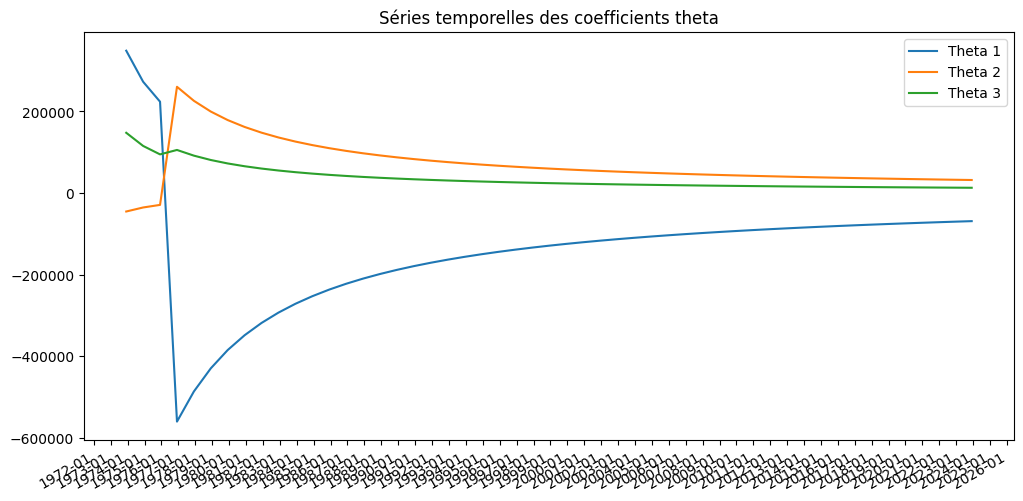

In [188]:
# Plot des séries temporelles pour chaque coefficient theta à travers T périodes de temps.
time_series_optimal_theta = plot_theta_series(optimal_thetas)
time_series_optimal_theta


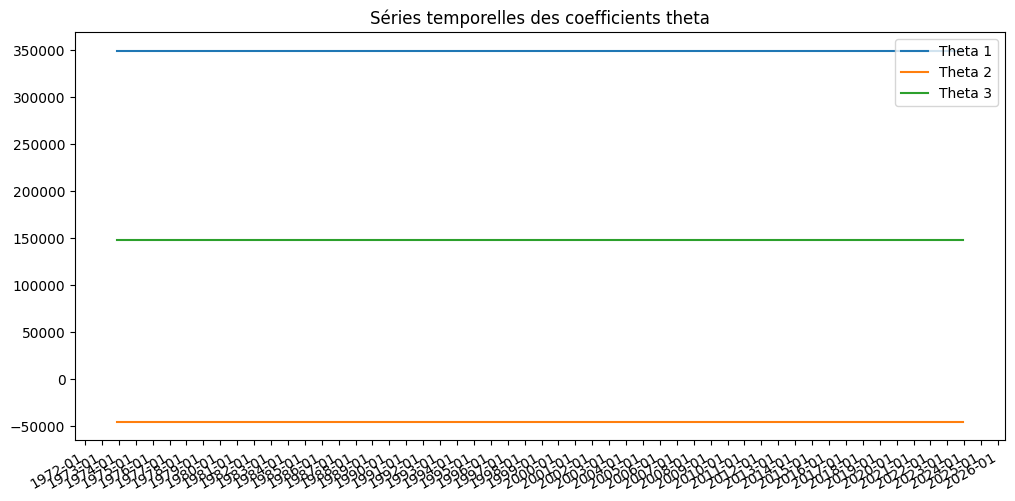

In [189]:
# Plot les séries temporelles pour chaque coefficient theta à travers T périodes de temps en utilisant la seconde méthode d'optimisation,
# avec les valeurs initiales des coefficients optimaux thetas estimés à partir de la période de temps précédente.
time_series_optimal_theta_second_method = plot_theta_series(optimal_thetas_second_method)
time_series_optimal_theta_second_method

### Calcul des poids de portefeuilles optimaux

In [190]:
def portfolio_weight_function(mkt_weights, MC_standardized, BM_standardized, MOM_standardized, optimal_theta):
    """
    Calcule les poids optimisés pour chaque actif en multipliant les coefficients optimaux par les caractéristiques standardisées 
    et en ajustant les poids du marché pour ces ajustements, comme décrit dans l'équation (3) de l'article.
    
    Parameters:
    - mkt_weights (pd.Series): Les poids du marché pour chaque actif au temps t.
    - MC_standardized (pd.Series): La caractéristique de capitalisation boursière standardisée pour chaque actif au temps t.
    - BM_standardized (pd.Series): La caractéristique de Book-to-Market standardisée pour chaque actif au temps t.
    - MOM_standardized (pd.Series): La caractéristique de Momentum standardisée pour chaque actif au temps t.
    - optimal_theta (np.array): Le vecteur de coefficients theta optimaux pour l'année en cours pour chaque caractéristique.
    
    Returns:
    - Les poids optimisés pour chaque actif, normalisés pour que leur somme soit égale à 1 comme dans l'équation (16) de l'article.
    """
    
    N = len(mkt_weights)
    optimized_weights = np.zeros(N)
    
    # Calculer les pondérations optimisées pour chaque actif en utilisant les coefficients optimaux
    # multipliés par les caractéristiques standardisées au temps t
    for i in range(N):
        initial_weight = mkt_weights.iloc[i]
        adjustment_caracteristics = (optimal_theta[0] * MC_standardized.iloc[i] + 
                      optimal_theta[1] * BM_standardized.iloc[i] + 
                      optimal_theta[2] * MOM_standardized.iloc[i]) / N
        optimized_weights[i] = initial_weight + adjustment_caracteristics

    # Assurer la positivité des poids optimisés avant de les normaliser 
    positive_weights = np.maximum(0, optimized_weights)
    
    # Normaliser les pondérations de portefeuille pour que leur somme soit égale à 1, 
    # comme la méthode décrite par l'équation (16) de l'article
    normalized_weights = positive_weights / np.sum(positive_weights)
    
    return normalized_weights

In [191]:
def calculate_optimized_weights_monthly(mkt_weights, MC_standardized, BM_standardized, MOM_standardized, optimal_thetas):
    """
    Calcule les poids optimisés du portefeuille pour chaque mois, en utilisant la fonction calculate_optimized_weights définies selon l'équation (3).
    
    Parameters:
    - 'mkt_weights' (pd.DataFrame): Les poids du marché pour chaque actif pour chaque mois.
    - 'MC_standardized' (pd.DataFrame): La caractéristique de capitalisation boursière standardisée pour chaque actif pour chaque mois.
    - 'BM_standardized' (pd.DataFrame): La caractéristique de Book-to-Market standardisée pour chaque actif pour chaque mois.
    - 'MOM_standardized' (pd.DataFrame): La caractéristique de Momentum standardisée pour chaque actif pour chaque mois.
    - 'optimal_thetas' (dict): Un dictionnaire où chaque clé est une année et la valeur est le vecteur de coefficients theta optimaux pour cette année 
    (12 fois le même vecteur par an).
    
    Returns:
    - 'pd.DataFrame': Un DataFrame où chaque ligne correspond à un mois et chaque colonne correspond à un actif, 
    et les valeurs sont les poids optimisés selon les ajustements pour les coefficients pour chaque actif.
    """
    
    
    optimized_weights_monthly = {}

    start_month = pd.Timestamp('1974-01-01')
    filtered_months = mkt_weights[start_month:].index

    for current_month in filtered_months:
        current_year = pd.Timestamp(year=current_month.year, month=12, day=1)
        if current_year not in optimal_thetas:
            continue
        mkt_weights_for_month = mkt_weights.loc[current_month]
        MC_standardized_month = MC_standardized.loc[current_month]
        BM_standardized_month = BM_standardized.loc[current_month]
        MOM_standardized_month = MOM_standardized.loc[current_month]
        
        # Appliquer les coefficients theta constants à travers les actifs et dans le temps
        optimized_weights = portfolio_weight_function(mkt_weights_for_month, MC_standardized_month, BM_standardized_month, MOM_standardized_month, optimal_thetas[current_year])
        
        optimized_weights_monthly[current_month] = optimized_weights
        
    # Convertir le dictionnaire en DataFrame pour une meilleure visualisation
    optimized_weights_monthly_df = pd.DataFrame.from_dict(optimized_weights_monthly, orient='index', columns=mkt_weights.columns)

    return optimized_weights_monthly_df

In [192]:
opt_weights_monthly      = calculate_optimized_weights_monthly(mkt_weights, MC_standardized, BM_standardized, MOM_standardized, optimal_thetas)
opt_weights_monthly

/var/folders/gm/cwbp26c51d14t923q1b9pdn00000gn/T/ipykernel_99104/4292234266.py:34: RuntimeWarning: invalid value encountered in divide
  normalized_weights = positive_weights / np.sum(positive_weights)


1,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
1974-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.940876,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.849475,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [193]:
def importClean_rf(csv_file_path):
    """
    Cette fonction importe des données à partir du fichier CSV des 3 facteurs Fama-French, puis effectue un nettoyage de données
    et retourne un DataFrame contenant des données filtrées spécifiquement pour les taux sans risque dans la colonne 'RF'.

    Args:
        csv_file_path (str): Chemin vers le fichier CSV avec les données brutes.

    Return:
        DataFrame: DataFrame contenant les données nettoyées pour les taux sans risque.
    """
    
    
    # Importation des données en sautant les 3 premières lignes
    df = pd.read_csv(csv_file_path, skiprows=3)  

    # Renommage des colonnes pour faciliter la manipulation
    df.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RF']

    # Suppression des lignes dont la date ne correspond pas au format '%Y%m'
    df = df[df['Date'].str.match(r'^\d{6}$', na=False)]

    # Conversion de 'Date' en datetime
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m')

    # Conversion de 'RF' en float
    df['RF'] = df['RF'].astype(float)
    
    # Filtrage des colonnes 
    df = df[['Date', 'RF']] 
    
    # Mise en index de la colonne 'Date'
    df.set_index('Date', inplace=True)
    
    return df

In [194]:
df_rf = importClean_rf('/Users/thomasdeconinck/Downloads/Gestion-de-Portefeuille-Devoir-2/Partie A/Data /F-F_Research_Data_Factors.CSV')

In [195]:
def calculate_portfolio_returns(opt_weights_monthly, mkt_weights, returns):
    """
    Calcule les rendements du portefeuille optimisé et du portefeuille de marché (Benchmark portfolio) selon les poids mensuels optimisés avec l'équation (3)
    et les rendements des actifs.

    Parameters:
    - opt_weights_monthly (DataFrame) : DataFrame contenant les poids mensuels du portefeuille parametric optimisé.
    - mkt_weights (DataFrame) : DataFrame contenant les poids du portefeuille de marché pour chaque actif.
    - returns (DataFrame) : DataFrame contenant les rendements des actifs shiftés d'une période. 

    Return:
    - Tuple contenant deux DataFrames : les rendements mensuels du portefeuille optimisé et les rendements mensuels du portefeuille de marché.
    """
    
    
    # Calculer les rendements du portefeuille optimisé en utilisant les poids mensuels optimisés
    optimized_portfolio_returns = (opt_weights_monthly * returns.reindex(opt_weights_monthly.index)).sum(axis=1)/100

    # Aligner les dates des poids du portefeuille de marché avec celles des rendements des actifs
    mkt_weights_aligned = mkt_weights.reindex(returns.reindex(opt_weights_monthly.index).index)
    # Calculer les rendements du portefeuille de marché (Benchmark portfolio) en utilisant les dates alignées
    market_portfolio_returns = (mkt_weights_aligned * returns.reindex(opt_weights_monthly.index)).sum(axis=1)/100

    # Convertir les séries en DataFrame 
    optimized_port_returns = pd.DataFrame(optimized_portfolio_returns, columns=['Portfolio Monthly Return'])
    market_port_returns = pd.DataFrame(market_portfolio_returns, columns=['Portfolio Monthly Return'])

    return optimized_port_returns, market_port_returns

In [196]:
optimized_port_returns, market_port_returns  =  calculate_portfolio_returns(opt_weights_monthly, mkt_weights, returns)

In [197]:
market_port_returns

,Portfolio Monthly Return
1974-01-01,0.000387
1974-02-01,-0.022024
1974-03-01,-0.045404
1974-04-01,-0.039492
1974-05-01,-0.022076
...,...
2023-08-01,-0.048094
2023-09-01,-0.026172
2023-10-01,0.093104
2023-11-01,0.051857


In [198]:
def format_value(val):
    """
    Cette fonction formate les valeurs numériques pour l'affichage, en utilisant un format de chaîne de caractères spécifié.
    
    Paramètres :
    - val (float) : Valeur numérique à formater.
    """
    
    
    return "{:.4f}".format(val)


def annualized_statistics_and_sharpe_ratios(strategies_results, periods, df_rf, is_decimal=False):
    """
    Calcule les statistiques annualisées pour les rendements hors échantillon de différentes stratégies de portefeuille sur des périodes spécifiées,
    et détermine les ratios de Sharpe annuels pour ces stratégies.

    Parameters:
    - strategies_results (dict) : Dictionnaire de DataFrames, où chaque clé représente le nom d'une stratégie et chaque valeur est
    un DataFrame contenant les résultats pour les poids optimaux de cette stratégie, y compris les 'Rendements Mensuels du Portefeuille'.
    - periods (liste de tuples) : Liste de tuples contenant la date de début et la date de fin d'une période à analyser,
    au format ('AAAA-MM-JJ', 'AAAA-MM-JJ').
    - df_rf (DataFrame) : DataFrame contenant les taux sans risque mensuels.
    - is_decimal (bool) : Booléen indiquant si les rendements sont en pourcentage (False) ou en décimal (True) pour le calcul.

    Return:
    - DataFrame contenant la moyenne annualisée et l'écart-type annualisé des rendements mensuels du portefeuille, ainsi que les ratios de Sharpe
    pour chaque stratégie et chaque période spécifiée.
    """
    
    
    results = []

    # Calculer le taux sans risque mensuel moyen et l'annualiser selon la formule du taux de rendement annuel composé (CAGR), 
    # pour obtenir le taux sans risque annuel moyen
    mean_rf_monthly = df_rf['RF'].mean()
    mean_rf_annual = ((1 + mean_rf_monthly/100) ** 12 - 1) 
    
    # Convertir en pourcentage pour faciliter les manipulations par la suite
    mean_rf_annual *= 100

    for strategy_name, strategy_results in strategies_results.items():
        for start_date, end_date in periods:
            # Filtrer les résultats de la stratégie pour la période spécifiée
            period_returns = strategy_results['Portfolio Monthly Return'].loc[start_date:end_date]

            # Calculer la moyenne et l'écart-type des rendements mensuels du portefeuille pour la période indiquée
            mean_return_monthly = period_returns.mean()
            std_return_monthly = period_returns.std()

            # Annualiser la moyenne et l'écart-type des rendements mensuels, avec la formule du taux de rendement annuel composé (CAGR)
            mean_return_annualized = (1 + mean_return_monthly/100) ** 12 - 1 if not is_decimal else (1 + mean_return_monthly) ** 12 - 1
            std_return_annualized = std_return_monthly * np.sqrt(12) if not is_decimal else std_return_monthly * np.sqrt(12) * 100
            
            # Convertir en pourcentage pour faciliter les manipulations par la suite
            mean_return_annualized = mean_return_annualized * 100 

            # Calculer le ratio de Sharpe annuel pour chaque stratégie et période
            sharpe_ratio = (mean_return_annualized - mean_rf_annual) / std_return_annualized

            # Appliquer le formatage adapté à la valeur du ratio de Sharpe
            formatted_mean_return = format_value(mean_return_annualized)
            formatted_std_deviation = format_value(std_return_annualized)
            formatted_sharpe_ratio = format_value(sharpe_ratio)

            # Ajouter les résultats à la liste
            results.append({
                'Strategy': strategy_name,
                'Start Date': start_date,
                'End Date': end_date,
                'Annualized Mean Return': formatted_mean_return,
                'Annualized Std Deviation': formatted_std_deviation,
                'Sharpe Ratio': formatted_sharpe_ratio
            })

    # Créer un DataFrame à partir de la liste des résultats
    results_df = pd.DataFrame(results)

    # Définir les noms des stratégies et les périodes comme index du DataFrame
    results_df.index = pd.MultiIndex.from_frame(results_df[['Strategy', 'Start Date', 'End Date']])
    results_df = results_df.drop(columns=['Strategy', 'Start Date', 'End Date'])

    return results_df

In [199]:
# Appeler la fonction qui calcul le rendement annuel moyen annualisé, la volatilité moyenne annualisée et le ratio de Sharpe 
# pour le portefeuille optimisé et le portefeuille de marché
Sharpe_ratio_df         = annualized_statistics_and_sharpe_ratios({
    'Optimized Portfolio': optimized_port_returns,
    'Market Portfolio': market_port_returns},
[('1974-01-01', '2023-12-01')],df_rf, is_decimal=True)
Sharpe_ratio_df

,,,Annualized Mean Return,Annualized Std Deviation,Sharpe Ratio
Strategy,Start Date,End Date,,,
Optimized Portfolio,1974-01-01,2023-12-01,17.2901,21.6911,0.6467
Market Portfolio,1974-01-01,2023-12-01,12.8762,15.8929,0.6049


In [200]:
optimized_port_returns

,Portfolio Monthly Return
1974-01-01,0.000000
1974-02-01,0.000000
1974-03-01,0.000000
1974-04-01,0.000000
1974-05-01,0.000000
...,...
2023-08-01,-0.061900
2023-09-01,-0.020500
2023-10-01,0.079313
2023-11-01,0.099731


In [201]:
market_port_returns

,Portfolio Monthly Return
1974-01-01,0.000387
1974-02-01,-0.022024
1974-03-01,-0.045404
1974-04-01,-0.039492
1974-05-01,-0.022076
...,...
2023-08-01,-0.048094
2023-09-01,-0.026172
2023-10-01,0.093104
2023-11-01,0.051857


In [202]:
def plot_cumulative_returns_partC(df, strategies):
    """
    Cette fonction trace les rendements cumulatifs pour les stratégies de portefeuilles spécifiées, de marché et optimisées selon les coefficients theta.

    Parameters:
    - df: DataFrame contenant les données de rendement pour les deux stratégies de portefeuilles.
    - strategies: Liste des deux stratégies à utiliser dans le tracé des rendements cumulatifs.
    """
    
    # Définir la taille de la figure à tracer
    plt.figure(figsize=(11,6))

    # Boucle sur chaque stratégie de portefeuille pour tracer les rendements cumulatifs 
    for strategy in strategies:
        # Récupérer les rendements de la stratégie
        mensual_returns = df[strategy]
        
        # Convertir les pourcentages en décimales et ajouter 1
        adjusted_returns = mensual_returns + 1 

        # Calculer les retours cumulatifs avec la fonction cumprod() qui fait le produit cumulatif des returns mensuels
        cumulative_returns = adjusted_returns.cumprod()
        
        # Tracer les rendements cumulatifs pour chaque stratégie
        plt.plot(cumulative_returns.index, cumulative_returns, label=strategy)
        
    
    plt.title('Rendements cumulatifs du portefeuille de benchmark et du portefeuille optimisé')
    plt.xlabel('Date')
    plt.ylabel('Rendements cumulatifs (%)')  
    plt.legend()
    plt.show()

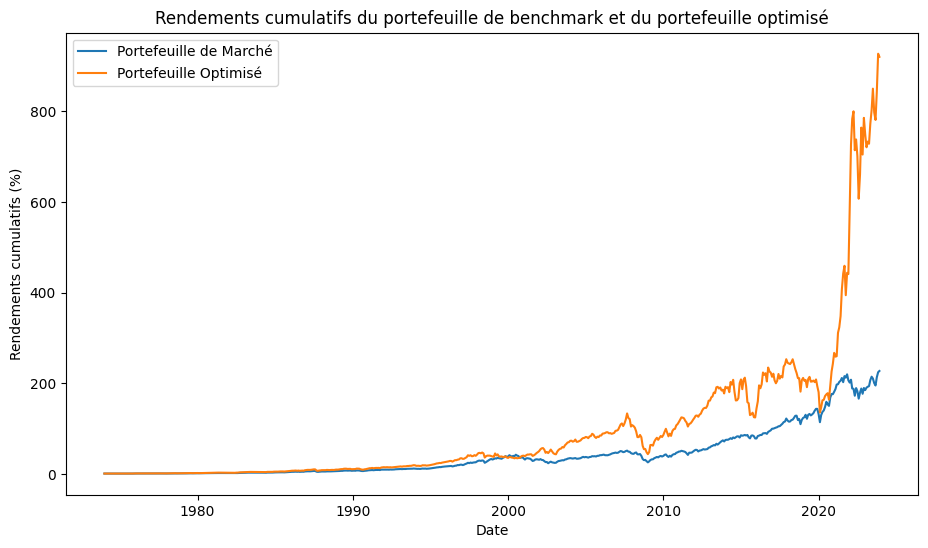

In [203]:
# Appeler la fonction plot_cumulative_returns avec les rendements cumulatifs des portefeuilles de marché et optimisé 
strategies = [ 'Portefeuille de Marché', 'Portefeuille Optimisé']

plot_cumulative_returns_partC({
    'Portefeuille Optimisé': optimized_port_returns,
    'Portefeuille de Marché': market_port_returns
}, strategies)

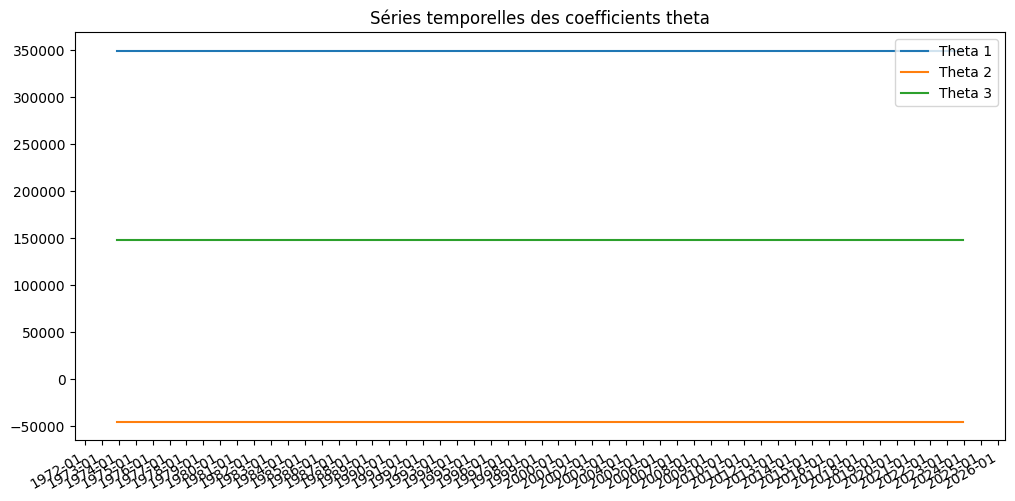

/var/folders/gm/cwbp26c51d14t923q1b9pdn00000gn/T/ipykernel_99104/4292234266.py:34: RuntimeWarning: invalid value encountered in divide
  normalized_weights = positive_weights / np.sum(positive_weights)


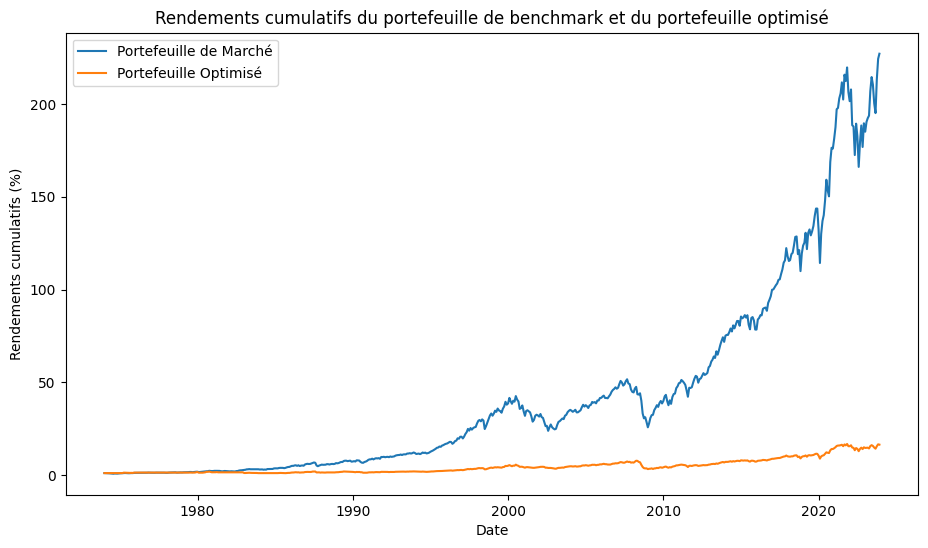

In [204]:


# Plot les séries temporelles pour chaque coefficient theta à travers T périodes de temps en utilisant la seconde méthode d'optimisation,
# avec les valeurs initiales des coefficients optimaux thetas estimés à partir de la période de temps précédente.
time_series_optimal_theta_second_method = plot_theta_series(optimal_thetas_second_method)
time_series_optimal_theta_second_method

# Formation des poids de portefeuilles optimisés pour chaque période de temps t mensuel, en utilisant les coefficients thetas estimés annuellement 
# et les données standardisées des 3 caractéristiques pour chaque période mensuelle t.
opt_weights_monthly_second_method      = calculate_optimized_weights_monthly(mkt_weights, MC_standardized, BM_standardized, MOM_standardized, optimal_thetas_second_method)
opt_weights_monthly_second_method

# Calcul des rendements mensuels des portefeuilles optimisés et du portefeuille de marché pour chaque période de temps t, en utilisant les poids de portefeuilles optimisés selon la seconde méthode.
optimized_port_returns_second_method, market_port_returns_second_method  = calculate_portfolio_returns(opt_weights_monthly_second_method, mkt_weights, returns)



# Résultats et comparaison des portefeuilles optimisés et du portefeuille de marché, pour la seconde méthode d'initialisation des coefficients thetas:

# 1) Calculer le rendement annuel moyen annualisé, la volatilité moyenne annualisée et le ratio de Sharpe pour le portefeuille optimisé et le portefeuille de marché
Sharpe_ratio_df                       = annualized_statistics_and_sharpe_ratios({
    'Optimized Portfolio': optimized_port_returns_second_method,
    'Market Portfolio': market_port_returns_second_method},
[('1974-01-01', '2023-12-01')],df_rf, is_decimal=True)
Sharpe_ratio_df

# 2) Calculer les rendements cumulés pour le portefeuille optimisé et le portefeuille de marché et tracer ces rendements cumulés

strategies                           = [ 'Portefeuille de Marché', 'Portefeuille Optimisé']

plot_cumulative_returns_partC({
    'Portefeuille Optimisé': optimized_port_returns_second_method,
    'Portefeuille de Marché': market_port_returns_second_method
}, strategies)